## Overview

In [321]:

#This code seeks to build a PINN that returns the concentration of gases and temperature across discretized points in an ammonia cracking reactor.

"""
This is achieved in the following steps:

  1. Import a PDE solver for the CDRS Equation for Ammonia Cracking and use it to solve for the concentration of gases and temperature across discretized points in times t.
  2. Outline the structure of an NN and initialise random parameters.
  3. Construct Pseudoinverse Matrix Ax = b and obtain x.
  4. Obtain fitness of NN by computing Data Loss and Physics Loss
  5. Recalibrate Parameters
"""

'\nThis is achieved in the following steps:\n\n  1. Import a PDE solver for the CDRS Equation for Ammonia Cracking and use it to solve for the concentration of gases and temperature across discretized points in times t.\n  2. Outline the structure of an NN and initialise random parameters.\n  3. Construct Pseudoinverse Matrix Ax = b and obtain x.\n  4. Obtain fitness of NN by computing Data Loss and Physics Loss\n  5. Recalibrate Parameters\n'

## Imports

In [ ]:
from Compiled_helper_functions import *

In [323]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from jax.scipy.linalg import solve

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

get_ipython().system('pip install evojax')
from evojax.util import get_params_format_fn

/opt/anaconda3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [324]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

## Import Steady State Solution

In [ ]:
ysteady = np.load("steady_state_solution.npy")

y_steady = jnp.array(ysteady)

In [326]:
# NH3 and T_x sol
#y_steady = y[-1]
reac = Reac() # Instantiate Reac after reload
print(reac.Nx)
oper = Oper(reac) # Instantiate Oper after reload
print(f"Shape of y_steady: {y_steady.shape}") # Added this line to print the shape
y_steady_reshaped = y_steady.reshape(reac.Ns + 1, reac.Nx, order ='C')
y_shortened = y_steady_reshaped
Y_NH3 = y_shortened[0]
T_x = y_shortened[-1]

sol = y_shortened.reshape(1,-1, order = 'C')


ysol = jnp.concatenate([Y_NH3, T_x]).T

print(T_x)

print(Y_NH3)

1001
Shape of y_steady: (5005,)
[771.5        771.69816615 771.78559674 ... 772.75078356 772.75085287
 772.75089892]
[0.995      0.99469436 0.99440447 ... 0.90717951 0.90712657 0.90709414]


## Outline Structure of NN and Initialise Random Parameters


In [327]:
# PINN
# TRY to split into 2 fs also

n_l = 3
class PINN(nn.Module):
    """PINNs"""
    def setup(self):
      #single hidden layer
        self.layers = [#nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       #jnp.sin,
                       #nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       #nn.swish,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       nn.swish,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       nn.swish,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform(), use_bias=True),
                       nn.swish,
                       ]
        #self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)


    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        # t = inputs
        x = inputs
        def get_u(x):
            # f = t / 10 - 0.4
            f = x # TRY THIS
            fs = []
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                """For sin activation"""
                if (i == 0):
                    pre_act = f
                if (i%2 != 0):
                    fs.append(f)
            fs = jnp.hstack(fs) #stop at the hidden layer before output
            #u = self.last_layer(f)
            return f, pre_act, fs

        f, pre_act, fs = get_u(x)

        # obtain f_t
        def get_f_dir(get_u, x):
            # f_t = jacfwd(get_u)(t)  # much faster (10x) than u_xx, f_xx = hessian(get_u)(x, y)
            f_x = jacfwd(lambda x: get_u(x)[0])(x)  # much faster (10x) than u_xx, f_xx = hessian(get_u)(x, y)
            f_xx = jacfwd(jacfwd(lambda x: get_u(x)[0]))(x)

            f_x = jnp.squeeze(f_x, axis= -1)
            f_xx = jnp.squeeze(f_xx, axis= (-1,-2))
            print(f_xx.shape)
            return f_xx, f_x

        f_dir_vmap = vmap(get_f_dir, in_axes=(None, 0))
        f_xx, f_x = f_dir_vmap(get_u, x)


        outputs = jnp.hstack([f, f_x, f_xx])

        return outputs, pre_act

In [328]:
# choose seed
seed = 10
key, rng = random.split(random.PRNGKey(seed))

# dummy input
a = random.normal(key, [1, 1]) #only for x

# initialization call
#n_nodes = 512
# n_nodes = 350
# n_nodes = 128
n_nodes = 256 # may be overfitted
NH3_nodes = n_nodes // 2

model = PINN()
params = model.init(key, a)
num_params, format_params_fn = get_params_format_fn(params)

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

# for inverst problem - append params to include 2 more parameters
key, rng = random.split(rng) # update random generator
# ini_a = random.normal(key, [1, n_e + 1]) #one for lmbda, other for lambda
ini_a = random.normal(key, [1, 1]) #one for lmbda, other for lambda
params = jnp.append(params, ini_a)
print(ini_a)

(256,)
[[0.27489732]]


## Evaluating PDE Constants

In [329]:
def regularization_factor(params):
  reg = 10**(nn.tanh(params)* 10)

  return reg

In [330]:
def eval_loss(params):

  # Apply Model
  shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
  #jax.debug.print("shaped_xvals {x}", x=shaped_xvals)
  pred, pre_act = model.apply(format_params_fn(params[:-1]), shaped_xvals)
  f, f_x, f_xx = jnp.split(pred, 3, axis=1)
  #print("f", f.shape)
  #print("f_x", f_x.shape)
  #print("f_xx", f_xx.shape)

  #f_x = jnp.ones_like(f_x)
  #f_xx = jnp.ones_like(f_xx)

  # Initial Guess of NH3 and T
  """
  Random Generation
  key1, key2, rng = jax.random.split(key, 3)
  Y_NH3 = jax.random.normal(key1, [1, reac.Nx])
  T_x = jax.random.normal(key2, [1, reac.Nx])
  """


  coeffs = gen_coeffs(y_steady, reac, oper)
  #jax.debug.print("lambda / Cpg: {t}", t = coeffs[:5,6])
  #jax.debug.print("ug/ac: {t}", t = coeffs[:5,7])
  #jax.debug.print("RT: {t}", t = coeffs[:5,8])
  #jax.debug.print("coeffs: {c}", c= coeffs.T)

  # Split NN
  f_NH3 = f[:, :NH3_nodes]
  f_x_NH3 = f_x[:, :NH3_nodes]
  f_xx_NH3 = f_xx[:, :NH3_nodes]

  f_T = f[:, NH3_nodes:]
  f_x_T = f_x[:, NH3_nodes:]
  f_xx_T = f_xx[:, NH3_nodes:]

  # Generate Matrix A
  pde_A1_left = coeffs[:,0].reshape(-1,1) * f_xx_NH3 + coeffs[:,1].reshape(-1,1) * f_x_NH3
  pde_A1 = jnp.hstack([pde_A1_left, jnp.zeros_like(f_NH3)])
  bc_NH3_A = jnp.hstack([f_NH3[0], jnp.zeros_like(f_NH3[0])])
  bc2_NH3_A = jnp.hstack([f_x_NH3[-1], jnp.zeros_like(f_x_NH3[-1])])
  A1 = pde_A1.at[0].set(bc_NH3_A)
  A1 = A1.at[-1].set(bc2_NH3_A)

  pde_A2_right = coeffs[:,6].reshape(-1,1) * f_xx_T + coeffs[:,7].reshape(-1,1) * f_x_T
  pde_A2 = jnp.hstack([jnp.zeros_like(f_T), pde_A2_right])
  bc_T_A = jnp.hstack([jnp.zeros_like(f_T[0]), f_T[0]]) * 1e3
  bc2_T_A = jnp.hstack([jnp.zeros_like(f_x_T[-1]), f_x_T[-1]]) * 1e3
  A2 = pde_A2.at[0].set(bc_T_A)
  A2 = A2.at[-1].set(bc2_T_A)

  A = jnp.vstack([A1, A2])


  #jax.debug.print("A.shape: {a}", a=A.shape)
  #jax.debug.print("A2: {a}", a= A2)


  """
  def A_warn():
    jax.debug.print("A is approaching 0")

  A_threshold = 1e-9
  jax.lax.cond(jnp.all(jnp.abs(A)) < A_threshold, A_warn, lambda: None)
  """
  # Generate RHS

  reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
  #jax.debug.print("reg: {r}", r = reg)

  # Generate RHS
  pde_b1 = -coeffs[:,2].reshape(-1,1)
  b1 = pde_b1.at[0].set(jnp.array(0.995))
  b1 = b1.at[-1].set(jnp.array(0.0))

  pde_b2 = -coeffs[:,8].reshape(-1,1)
  b2 = pde_b2.at[0].set(jnp.array(771.5) * 1e3)
  b2 = b2.at[-1].set(jnp.array(0.0) * 1e3)
  b2 = b2 / 700

  b = jnp.vstack([b1, b2])
  #jax.debug.print("b: {b}", b = b)

  As, bs = reg*jnp.eye(A.shape[1]) + (A.T@A), A.T@b #this is least squares  (A.T@A)
  w_PI = solve(As, bs)

  #jax.debug.print("w = {w}", w = w_PI[:n_nodes])

  """
  jax.debug.print("f, {f}", f = f)
  jax.debug.print("f_x, {f}", f = f_x)
  jax.debug.print("f_xx, {f}", f = f_xx)
  """

  pred1 = f_NH3 @ w_PI[:NH3_nodes]
  pred2 = f_T @ w_PI[NH3_nodes:] * 700

  pred = jnp.vstack([pred1, pred2])



  pde_residual = A @ w_PI
  pde_residual_A1 = pde_residual[1:reac.Nx-1]
  pde_residual_A2 = pde_residual[-(reac.Nx-1):-1]
  pde_right = b
  pde_right_A1 = pde_right[1:reac.Nx-1]
  pde_right_A2 = pde_right[-(reac.Nx-1):-1]

  pde_residual = jnp.vstack([pde_residual_A1, pde_residual_A2])
  pde_right = jnp.vstack([pde_right_A1, pde_right_A2])

  pde_loss = jnp.mean(jnp.square(pde_residual - pde_right))


  # ssr, mse, rl2
  ssr = jnp.sum((b - A @ w_PI)**2)
  # mse = jnp.mean(jnp.square(gt_solver - pred_all))
  #mse = jnp.sum(jnp.mean(jnp.square(sol - pred_all), axis=0))
  mse1 = jnp.sum(jnp.mean(jnp.square(Y_NH3 - pred1), axis=0))
  mse2 = jnp.sum(jnp.mean(jnp.square((T_x  - pred2)), axis=0))

  mse = mse1 + mse2

  rl2_A = jnp.linalg.norm(Y_NH3.reshape(-1, 1) - pred1) / jnp.linalg.norm(Y_NH3.reshape(-1, 1))

  rl2_B = jnp.linalg.norm(T_x.reshape(-1, 1) - pred2) / jnp.linalg.norm(T_x.reshape(-1, 1))

  rl2 = rl2_A + rl2_B * 1e2
  loss = rl2 + pde_loss / 1e1

  return loss, (ssr, pde_loss, rl2_A, rl2_B)

loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))
# loss_grad = jax.value_and_grad(eval_loss, has_aux=True)



# weights update
@jit
def update(params, opt_state):
    (loss, (ssr, pde_loss, rl2_A, rl2_B)), grad0 = loss_grad(params)
    return loss, ssr, pde_loss, rl2_A, rl2_B, grad0

@jit
def update1(params, opt_state, grads):
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state



In [331]:
# optimizer
max_iters = 2000
# max_iters = 200
max_lr = 2e-2


lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=0,
                                                  decay_steps= (max_iters), end_value=1e-6)
#lr_scheduler = optax.cosine_decay_schedule(init_value=max_lr, decay_steps=max_iters * 2)


optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
# optimizer = optax.adam(learning_rate=0.001) # Choose the method
opt_state = optimizer.init(params)


# training iteration
runtime = 0
train_iters = 0

store = []
para_all = {}

mse_best = 1e10
while (train_iters <= max_iters):
    # mini-batch updater
    # key, rng = random.split(rng) # update random generator
    # if (train_iters % 20 == 0):
    #     para_all[train_iters] = params
    para_all[train_iters] = params

    losses, ssrs, pde_losses, rl2_As, rl2_Bs, grads = 0, 0, 0, 0, 0, 0
    loss, ssr, pde_loss, rl2_A, rl2_B, grad0 = update(params, opt_state)
    grads = grads + grad0
    losses = losses + loss
    ssrs = ssrs + ssr
    pde_losses = pde_losses + pde_loss
    rl2_As = rl2_As + rl2_A
    rl2_Bs = rl2_Bs + rl2_B
    params, opt_state = update1(params, opt_state, grads)

    if jnp.isnan(losses).any() or jnp.isnan(grads).any():
      print(f"NaN detected at iteration {train_iters}. Stopping training.")
      break




    # append weights
    if (train_iters % 1 == 0):
        reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
        print ('iter. = %05d,  time = %03ds,  loss = %.4e,  ssr = %.4e,  pde_loss = %.4e, rl2_A = %.4e, rl2_B = %.4e, reg = %.4e'%(train_iters, runtime, losses, ssrs, pde_losses, rl2_As, rl2_Bs, reg))
        store.append([train_iters, runtime, losses, pde_losses, ssrs, rl2_As, rl2_Bs])

    #if mses < mse_best:
     #   mse_best = mses
      #  jnp.save('best_0', para_all[train_iters])

    train_iters += 1

store = jnp.array(store)


(256,)
iter. = 00000,  time = 000s,  loss = 9.9743e+01,  ssr = 1.2147e+06,  pde_loss = 1.1983e-03, rl2_A = 1.0524e+00, rl2_B = 9.8690e-01, reg = 3.1273e+02
iter. = 00001,  time = 000s,  loss = 4.0414e+00,  ssr = 1.4489e+02,  pde_loss = 5.3805e-02, rl2_A = 1.0570e+00, rl2_B = 2.9790e-02, reg = 2.2577e+02
iter. = 00002,  time = 000s,  loss = 2.5166e+00,  ssr = 4.1151e+00,  pde_loss = 1.4732e-03, rl2_A = 1.0523e+00, rl2_B = 1.4641e-02, reg = 1.7600e+02
iter. = 00003,  time = 000s,  loss = 2.3641e+00,  ssr = 2.8651e+00,  pde_loss = 9.3761e-04, rl2_A = 1.0408e+00, rl2_B = 1.3233e-02, reg = 1.4684e+02
iter. = 00004,  time = 000s,  loss = 2.3112e+00,  ssr = 2.6734e+00,  pde_loss = 8.7439e-04, rl2_A = 1.0115e+00, rl2_B = 1.2996e-02, reg = 1.2890e+02
iter. = 00005,  time = 000s,  loss = 2.1950e+00,  ssr = 6.7360e+00,  pde_loss = 2.9665e-03, rl2_A = 9.4524e-01, rl2_B = 1.2494e-02, reg = 1.1710e+02
iter. = 00006,  time = 000s,  loss = 2.0160e+00,  ssr = 3.7682e+00,  pde_loss = 1.5699e-03, rl2_A =

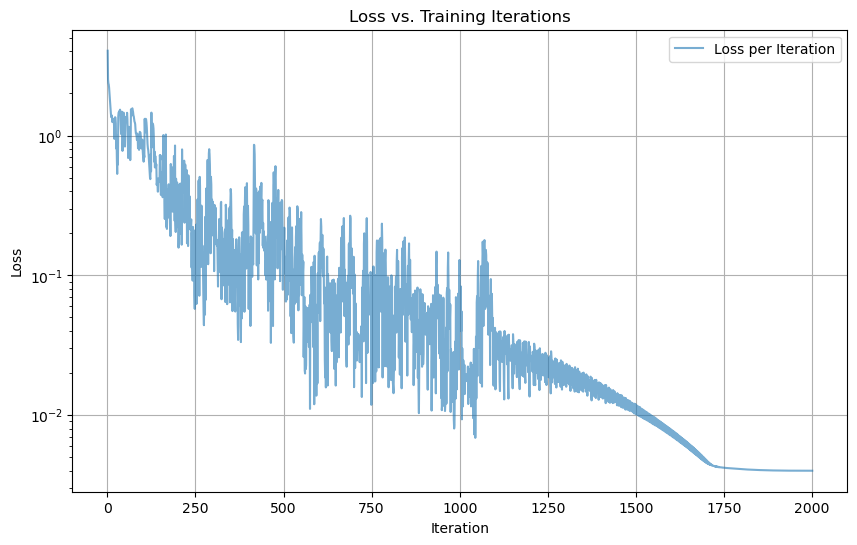

In [332]:
# Extract iteration and Loss data from the 'store' array
iterations = store[:, 0]
loss_values = store[:, 2]  # Loss is the 3rd column (index 2)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:],loss_values[1:], label='Loss per Iteration', alpha=0.6)

# Scale Axes
plt.xscale('linear')
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

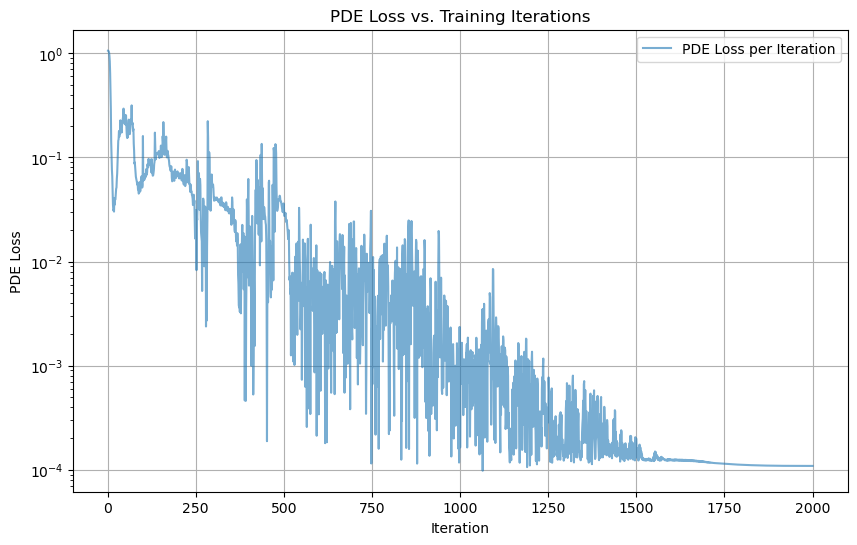

In [333]:

# Extract iteration and pde_loss data from the 'store' array
iterations = store[:, 0]
pde_loss_values = store[:, 5]  # pde_loss is the 6th column (index 5)

# Create the plot for PDE loss
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:], pde_loss_values[1:], label='PDE Loss per Iteration', alpha=0.6)

# Scale Axes
plt.xscale('linear')
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('PDE Loss')
plt.title('PDE Loss vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


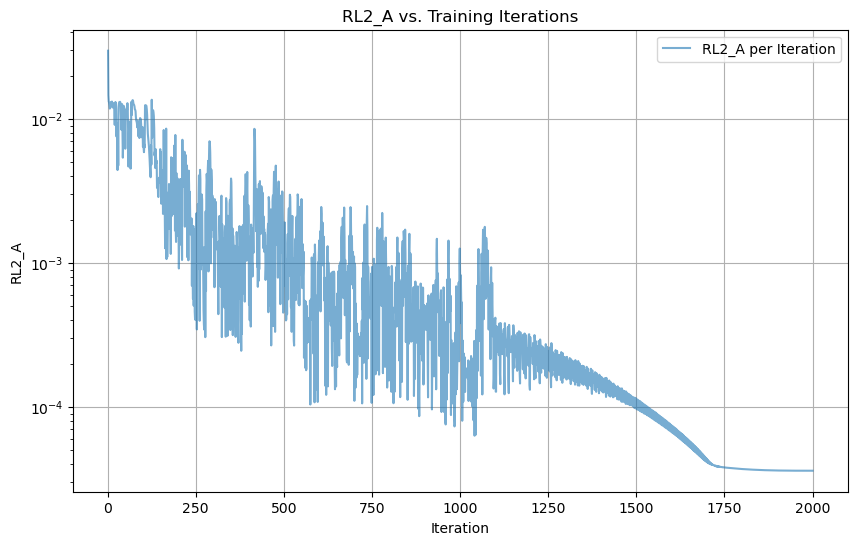

In [334]:
# Extract iteration and pde_loss data from the 'store' array
iterations = store[:, 0]
rl2_A_vals = store[:, 6]  # Rl2_A is the 7th column (index 6)

# Create the plot for RL2_A loss
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:], rl2_A_vals[1:], label='RL2_A per Iteration', alpha=0.6)

# Scale Axes
plt.xscale('linear')
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('RL2_A')
plt.title('RL2_A vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

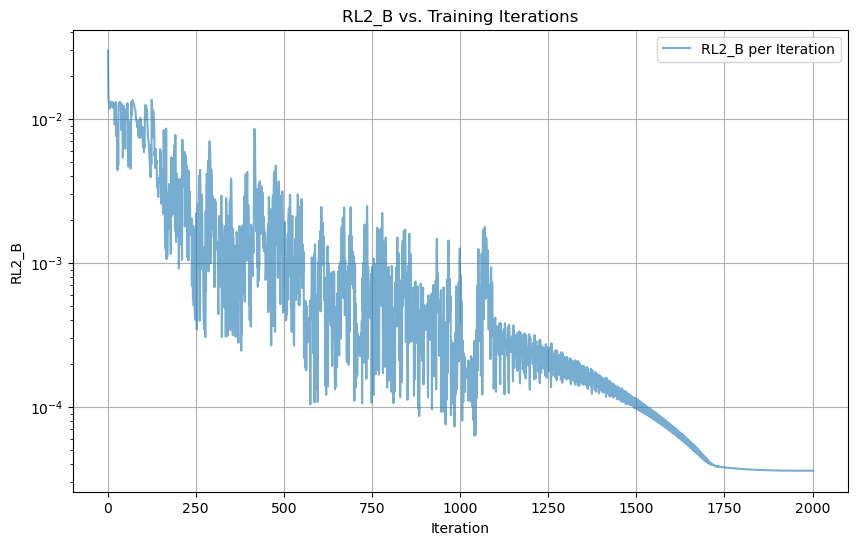

In [335]:
# Extract iteration and RL2_B data from the 'store' array
iterations = store[:, 0]
rl2_B_vals = store[:, 7]  # RL2_B is the 8th column (index 7)

# Create the plot for RL2_B loss
plt.figure(figsize=(10, 6))
plt.plot(iterations[1:], rl2_B_vals[1:], label='RL2_B per Iteration', alpha=0.6)

# Scale Axes
plt.xscale('linear')
plt.yscale('log')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('RL2_B')
plt.title('RL2_B vs. Training Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

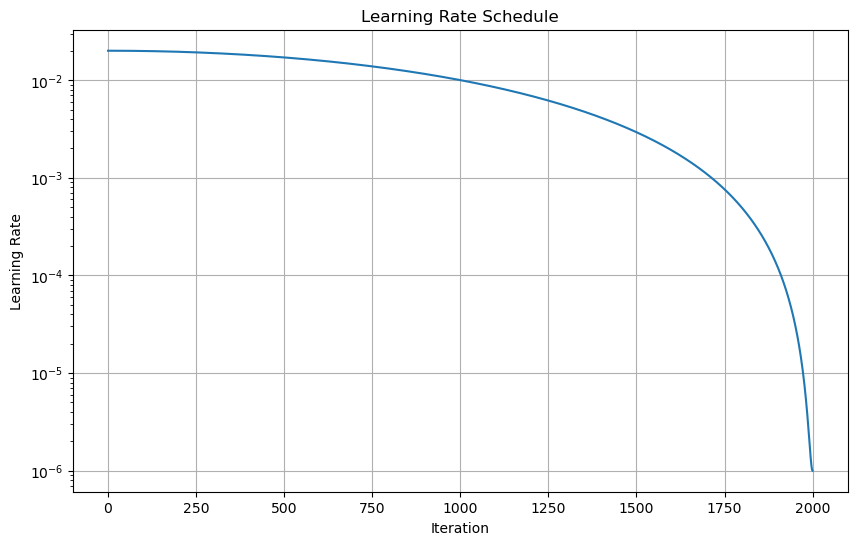

In [336]:
# Generate learning rate values over iterations
lrs = lr_scheduler(jnp.arange(max_iters + 1))

# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(jnp.arange(max_iters + 1), lrs)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True)
plt.show()

In [337]:
def eval_prediction(params):
  shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
  pred, pre_act = model.apply(format_params_fn(params[:-1]), shaped_xvals)
  f, f_x, f_xx = jnp.split(pred, 3, axis=1)


  coeffs = gen_coeffs(y_steady, reac, oper)

  # Split NN
  f_NH3 = f[:, :NH3_nodes]
  f_x_NH3 = f_x[:, :NH3_nodes]
  f_xx_NH3 = f_xx[:, :NH3_nodes]

  f_T = f[:, NH3_nodes:]
  f_x_T = f_x[:, NH3_nodes:]
  f_xx_T = f_xx[:, NH3_nodes:]

  # Generate Matrix A
  pde_A1_left = coeffs[:,0].reshape(-1,1) * f_xx_NH3 + coeffs[:,1].reshape(-1,1) * f_x_NH3
  pde_A1 = jnp.hstack([pde_A1_left, jnp.zeros_like(f_NH3)])
  bc_NH3_A = jnp.hstack([f_NH3[0], jnp.zeros_like(f_NH3[0])])
  bc2_NH3_A = jnp.hstack([f_x_NH3[-1], jnp.zeros_like(f_x_NH3[-1])])
  A1 = pde_A1.at[0].set(bc_NH3_A)
  A1 = A1.at[-1].set(bc2_NH3_A)

  pde_A2_right = coeffs[:,6].reshape(-1,1) * f_xx_T + coeffs[:,7].reshape(-1,1) * f_x_T
  pde_A2 = jnp.hstack([jnp.zeros_like(f_T), pde_A2_right])
  bc_T_A = jnp.hstack([jnp.zeros_like(f_T[0]), f_T[0]]) * 1e3
  bc2_T_A = jnp.hstack([jnp.zeros_like(f_x_T[-1]), f_x_T[-1]]) * 1e3
  A2 = pde_A2.at[0].set(bc_T_A)
  A2 = A2.at[-1].set(bc2_T_A)

  A = jnp.vstack([A1, A2])


  #jax.debug.print("A.shape: {a}", a=A.shape)
  #jax.debug.print("A2: {a}", a= A2)


  """
  def A_warn():
    jax.debug.print("A is approaching 0")

  A_threshold = 1e-9
  jax.lax.cond(jnp.all(jnp.abs(A)) < A_threshold, A_warn, lambda: None)
  """
  # Generate RHS

  reg = regularization_factor(params[-1]) #10**(nn.sigmoid(params[-1])*4 - 6)
  #jax.debug.print("reg: {r}", r = reg)

  # Generate RHS
  pde_b1 = -coeffs[:,2].reshape(-1,1)
  b1 = pde_b1.at[0].set(jnp.array(0.995))
  b1 = b1.at[-1].set(jnp.array(0.0))

  pde_b2 = -coeffs[:,8].reshape(-1,1)
  b2 = pde_b2.at[0].set(jnp.array(771.5) * 1e3)
  b2 = b2.at[-1].set(jnp.array(0.0) * 1e3)
  b2 = b2 / 700

  b = jnp.vstack([b1, b2])
  #jax.debug.print("b: {b}", b = b)

  As, bs = reg*jnp.eye(A.shape[1]) + (A.T@A), A.T@b #this is least squares  (A.T@A)
  w_PI = solve(As, bs)

  #jax.debug.print("w = {w}", w = w_PI[:n_nodes])

  """
  jax.debug.print("f, {f}", f = f)
  jax.debug.print("f_x, {f}", f = f_x)
  jax.debug.print("f_xx, {f}", f = f_xx)
  """

  pred1 = f_NH3 @ w_PI[:NH3_nodes]
  pred2 = f_T @ w_PI[NH3_nodes:] * 700

  return pred1, pred2, pre_act

(256,)


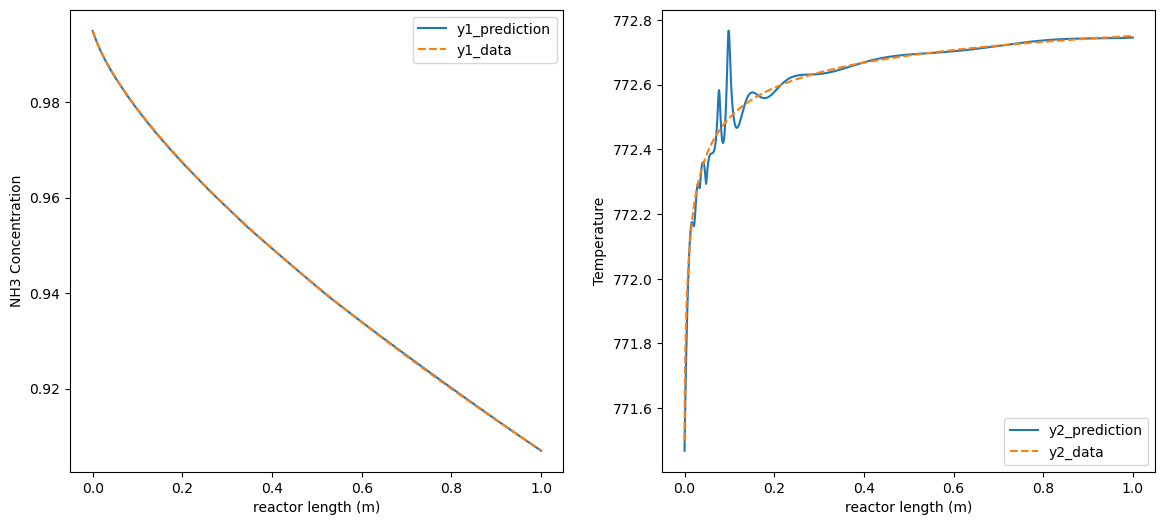

In [338]:
pred1, pred2, pre_act = eval_prediction(params)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
shaped_xvals = reac.xvals.reshape(reac.Nx, 1)
ax[0].plot(shaped_xvals, pred1, label='y1_prediction')
ax[0].plot(shaped_xvals, Y_NH3, label='y1_data', linestyle = "dashed")
ax[0].set_xlabel('reactor length (m)')
ax[0].set_ylabel('NH3 Concentration')
ax[0].legend()

ax[1].plot(shaped_xvals, pred2, label='y2_prediction')
ax[1].plot(shaped_xvals, T_x, label='y2_data', linestyle = "dashed")
ax[1].set_xlabel('reactor length (m)')
ax[1].set_ylabel('Temperature')
ax[1].legend()


In [340]:
rl2_A = jnp.linalg.norm(Y_NH3.reshape(-1, 1) - pred1) / jnp.linalg.norm(Y_NH3.reshape(-1, 1))
rl2_B = jnp.linalg.norm(T_x.reshape(-1, 1) - pred2) / jnp.linalg.norm(T_x.reshape(-1, 1))

print("rl2_B: %.4e" %(rl2_B))
print("rl2_A: %.4e" %(rl2_A))

rl2_B: 3.6046e-05
rl2_A: 1.0891e-04
